In [190]:
import pandas as pd
import re
from sklearn.metrics import confusion_matrix, classification_report
import plotly.express as px
import plotly.figure_factory as ff


In [192]:
# 1. Load input files
vader_df = pd.read_excel("vader_boe_speeches_sentiment.xlsx")
gpt_df = pd.read_excel("boe_sentiment_results.xlsx")
lexicon_df = pd.read_excel("LSE_DA_BoE_Employer_project_Sentiment-labelled_wordlist.xlsx")


In [193]:
# 2. Filter speeches for United Kingdom only
uk_df = vader_df[vader_df["country"].str.lower() == "united kingdom"].copy()


In [196]:
# 3. Create lexicon sets
positive_words = set(lexicon_df[lexicon_df["Positive"] == 1]["Word"].str.upper())
negative_words = set(lexicon_df[lexicon_df["Negative"] == 1]["Word"].str.upper())


In [198]:
# 4. Lexicon-based sentiment function
def lexicon_sentiment(text):
    if not isinstance(text, str): return "Neutral"
    words = re.findall(r'\b\w+\b', text.upper())
    pos = sum(w in positive_words for w in words)
    neg = sum(w in negative_words for w in words)
    if pos > neg:
        return "Positive"
    elif neg > pos:
        return "Negative"
    else:
        return "Neutral"
      

In [200]:
# 5. Apply lexicon sentiment analysis
uk_df["Lexicon_sentiment"] = uk_df["text"].apply(lexicon_sentiment)


In [201]:
# 6. Rename VADER sentiment column
uk_df.rename(columns={"Sentiment Label (VADER)": "Vader_sentiment"}, inplace=True)


In [204]:
# 7. Merge with GPT sentiment results
df = pd.merge(uk_df, gpt_df[["Reference", "Gpt_sentiment"]], left_on="reference", right_on="Reference", how="inner")


In [206]:
# 8. Standardize sentiment column formatting
for col in ["Gpt_sentiment", "Vader_sentiment", "Lexicon_sentiment"]:
    df[col] = df[col].str.strip().str.capitalize()


In [208]:
# 9. Agreement with VADER as baseline
df["agreement_gpt"] = df["Gpt_sentiment"] == df["Vader_sentiment"]
df["agreement_lexicon"] = df["Lexicon_sentiment"] == df["Vader_sentiment"]



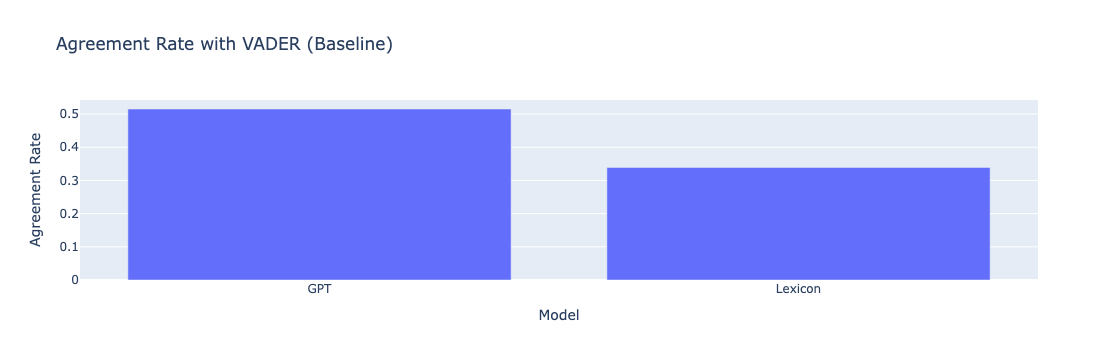

In [210]:
# 10. Plot agreement rate
agreement_data = pd.DataFrame({
    "Model": ["GPT", "Lexicon"],
    "Agreement Rate": [df["agreement_gpt"].mean(), df["agreement_lexicon"].mean()]
})
fig1 = px.bar(agreement_data, x="Model", y="Agreement Rate",
              title="Agreement Rate with VADER (Baseline)")
fig1.show()

This bar chart shows how often each model agrees with VADER sentiment labels:

* GPT agrees with VADER in about 51% of cases.

* Lexicon agrees with VADER only about 34% of the time.

Interpretation: GPT is significantly more aligned with VADER’s sentiment classification than the Lexicon-based method. This suggests that GPT captures contextual and nuanced sentiment signals in a way that is more consistent with how VADER evaluates text.

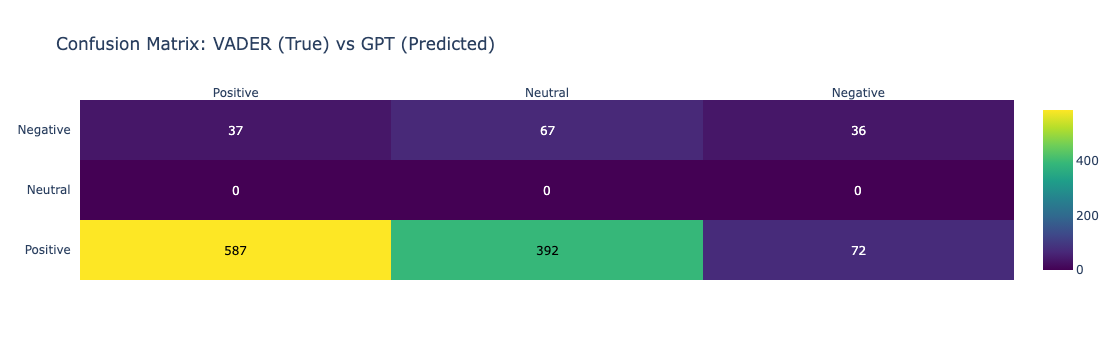

In [212]:
# 11. Confusion Matrix: VADER vs GPT
labels = ["Positive", "Neutral", "Negative"]
cm_vader_gpt = confusion_matrix(df["Vader_sentiment"], df["Gpt_sentiment"], labels=labels)
fig2 = ff.create_annotated_heatmap(
    z=cm_vader_gpt, x=labels, y=labels, colorscale="Viridis", showscale=True)
fig2.update_layout(title="Confusion Matrix: VADER (True) vs GPT (Predicted)")
fig2.show()

This matrix compares VADER sentiment labels (as ground truth) to GPT predictions.

* Most VADER-positive texts are correctly predicted as positive or neutral by GPT.

* However, GPT does not predict "Neutral" at all for any class.

* A notable portion of VADER-negative entries are misclassified by GPT as neutral or positive.

**Note:** <u> In the VADER framework, the "neutral" label does not refer to a final sentiment classification, but rather to the proportion of neutral words in the text. The actual compound score (used for classification) can be strongly positive or negative even if the neutral proportion is high. This can create a mismatch in expectations when comparing VADER with classifiers that use “Neutral” as a distinct output class.</u>

Interpretation: GPT seems to avoid assigning "Neutral" sentiment, and it tends to overpredict Positive, potentially interpreting formal or technical language in BoE speeches as sentimentally favorable.

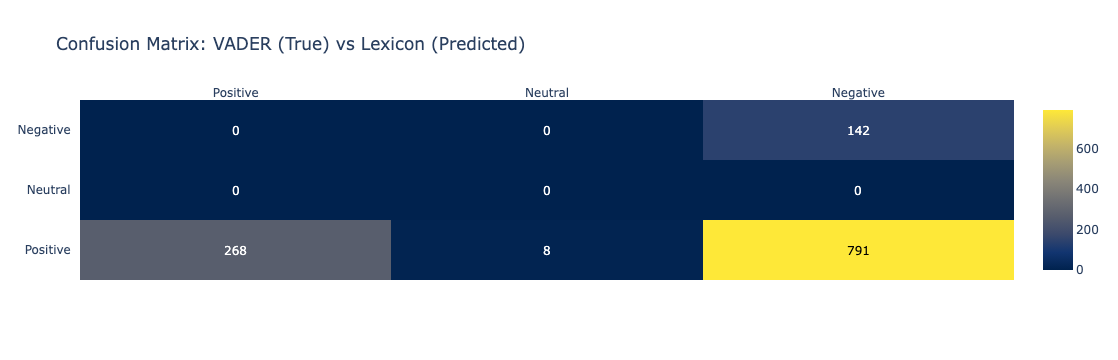

In [214]:
# 12. Confusion Matrix: VADER vs Lexicon
cm_vader_lex = confusion_matrix(df["Vader_sentiment"], df["Lexicon_sentiment"], labels=labels)
fig3 = ff.create_annotated_heatmap(
    z=cm_vader_lex, x=labels, y=labels, colorscale="Cividis", showscale=True)
fig3.update_layout(title="Confusion Matrix: VADER (True) vs Lexicon (Predicted)")
fig3.show()

This heatmap compares the Lexicon method’s predictions with VADER labels.

* The Lexicon approach severely misclassifies VADER-positive cases as negative.

* It fails to assign the Neutral label at all, similar to GPT.

* The precision for Negative is low, despite high recall, suggesting a large number of false positives.

Interpretation: Lexicon sentiment is too simplistic or rigid, likely because it counts positive/negative words without context. It overemphasizes negative sentiment, which causes widespread misclassification—especially for formal or technical language that includes cautionary terms (e.g., “risk,” “inflation”) even in positive contexts.

In [216]:
# 13. Classification Reports
print("Classification Report: VADER (True) vs GPT (Predicted)")
print(classification_report(df["Vader_sentiment"], df["Gpt_sentiment"], labels=labels))



Classification Report: VADER (True) vs GPT (Predicted)
              precision    recall  f1-score   support

    Positive       0.94      0.55      0.69      1067
     Neutral       0.00      0.00      0.00         0
    Negative       0.33      0.25      0.29       142

   micro avg       0.52      0.52      0.52      1209
   macro avg       0.42      0.27      0.33      1209
weighted avg       0.87      0.52      0.65      1209



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [218]:
print("Classification Report: VADER (True) vs Lexicon (Predicted)")
print(classification_report(df["Vader_sentiment"], df["Lexicon_sentiment"], labels=labels))


Classification Report: VADER (True) vs Lexicon (Predicted)
              precision    recall  f1-score   support

    Positive       1.00      0.25      0.40      1067
     Neutral       0.00      0.00      0.00         0
    Negative       0.15      1.00      0.26       142

    accuracy                           0.34      1209
   macro avg       0.38      0.42      0.22      1209
weighted avg       0.90      0.34      0.39      1209



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [220]:
# 14. Metrics from classification reports (entered manually)
metrics_data = {
    "Category": ["Positive", "Neutral", "Negative"] * 2,
    "Model": ["GPT"] * 3 + ["Lexicon"] * 3,
    "Precision": [0.94, 0.00, 0.33, 1.00, 0.00, 0.15],
    "Recall":    [0.55, 0.00, 0.25, 0.25, 0.00, 1.00],
    "F1-score":  [0.69, 0.00, 0.29, 0.40, 0.00, 0.26],
}
df_metrics = pd.DataFrame(metrics_data)

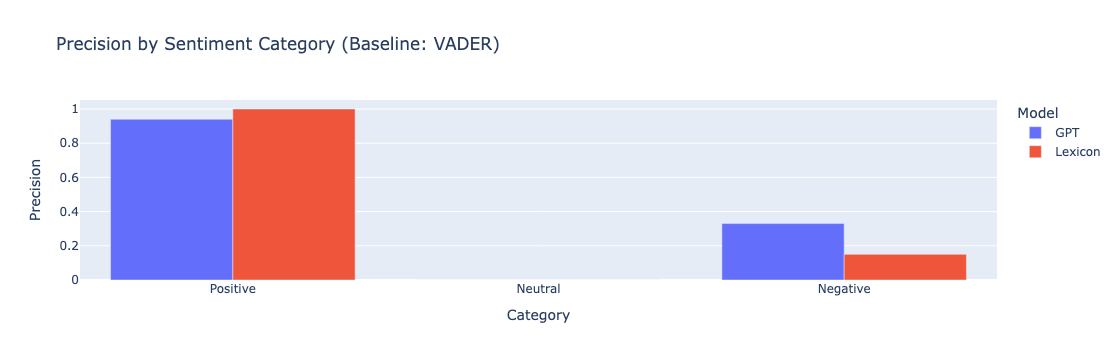

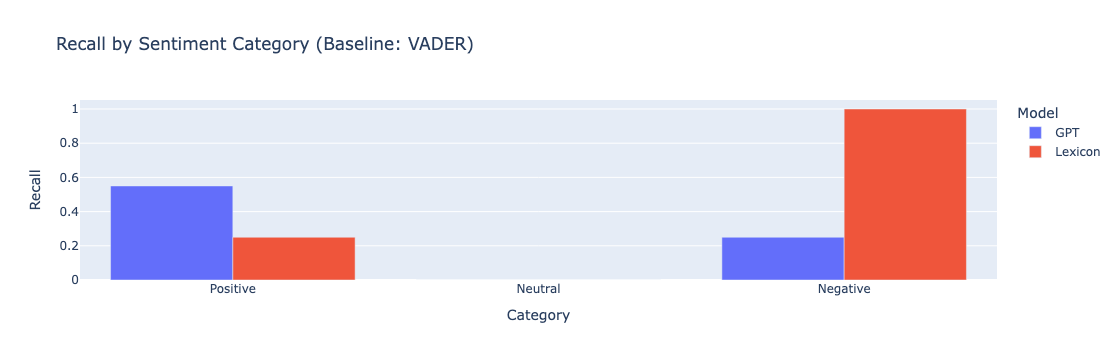

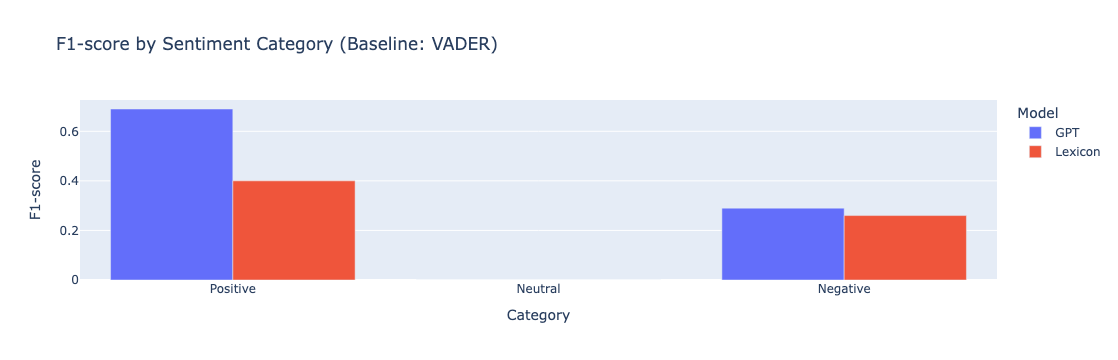

In [226]:
# 15. Visualize per-class metrics
for metric in ["Precision", "Recall", "F1-score"]:
    fig = px.bar(df_metrics, x="Category", y=metric, color="Model", barmode="group",
                 title=f"{metric} by Sentiment Category (Baseline: VADER)")
    fig.show()

The bar charts above compare Precision, Recall, and F1-score per sentiment category (Positive, Neutral, Negative) for GPT and Lexicon models, using VADER as the baseline (i.e., VADER labels are treated as ground truth).
* For the "Positive" category, GPT achieves higher F1-score and recall, while Lexicon has slightly better precision.
* For "Negative", Lexicon achieves perfect recall (i.e., it captures all negative cases from VADER), but has very low precision—indicating many false positives. GPT, by contrast, offers better precision but misses more true negatives (lower recall).
* For "Neutral", both models score zero across all metrics, likely because VADER does not assign any final "Neutral" sentiment labels.
  
Overall, GPT shows more balanced performance across sentiment classes, especially for "Positive" sentiment.

Lexicon is useful when recall of "Negative" sentiment is the top priority, but its performance is unbalanced.


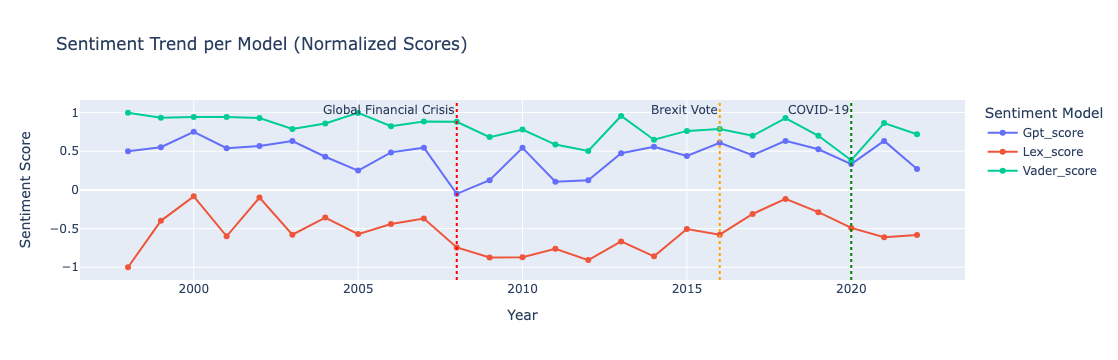

In [228]:
# 16. Sentiment trend over time
# Convert sentiments to numerical scores
df["Gpt_score"] = df["Gpt_sentiment"].map({"Negative": -1, "Neutral": 0, "Positive": 1})
df["Lex_score"] = df["Lexicon_sentiment"].map({"Negative": -1, "Neutral": 0, "Positive": 1})
df["Vader_score"] = df["compound"]  # already [-1, 1]

# Aggregate by year
trend_df = df.groupby("year")[["Gpt_score", "Lex_score", "Vader_score"]].mean().reset_index()

# Plot sentiment trend with events
fig = px.line(
    trend_df,
    x="year",
    y=["Gpt_score", "Lex_score", "Vader_score"],
    title="Sentiment Trend per Model (Normalized Scores)",
    markers=True,
    labels={"value": "Sentiment Score", "year": "Year", "variable": "Model"}
)

# Add major events
fig.add_vline(x=2008, line_dash="dot", line_color="red",
              annotation_text="Global Financial Crisis", annotation_position="top left")
fig.add_vline(x=2016, line_dash="dot", line_color="orange",
              annotation_text="Brexit Vote", annotation_position="top left")
fig.add_vline(x=2020, line_dash="dot", line_color="green",
              annotation_text="COVID-19", annotation_position="top left")

fig.update_layout(legend_title="Sentiment Model")
fig.show()

Observations by Model:
* VADER
    *  Shows smooth, high, and consistently positive sentiment over time.

    * Slight declines are visible around major crises (2008, 2020), but it never drops below neutral.

    * Reflects measured tone likely expected from institutional communication.

* GPT
    * Follows a similar pattern to VADER, but with sharper dips—notably in 2008 and 2020.

    * Slightly more reactive to external shocks.

    * Maintains general positivity otherwise, aligning with the BoE’s role in reassurance and stability.

* Lexicon-based
    * Consistently shows negative sentiment, even during periods of economic stability or recovery.

    * Peaks above 0 are rare; the tone appears pessimistic or overly critical.

    * Less reflective of the measured, reassuring stance typically expected in central bank communication.



Evaluation & Recommendation:
* Given the Bank of England’s mission to foster stability and confidence through its communications:

* VADER stands out as the most aligned with institutional tone, showing balance, mild variation, and strong correlation with crisis periods without exaggeration.

* GPT performs well as a close second—reactive but still aligned with broader macro events, and captures nuance better than lexicons.

* Lexicon-based sentiment appears too rigid and pessimistic, underestimating positive tone and likely misclassifying formal or technical language.



**Conclusion: Best Tool for the Bank of England Context**

VADER is currently the most appropriate model for tracking sentiment in Bank of England speeches, as it reflects the institution's tone and communication goals (stability, reassurance). 

GPT can supplement this, offering interpretability and deeper nuance—but its output should be validated.

The lexicon-based approach is not recommended due to persistent negative bias and poor sensitivity to context.